<a href="https://colab.research.google.com/github/Mevaourse/Classification-Indonesian-Fraud-SMS-using-NaiveBayes-and-IndoBert/blob/main/Evaluasi_Model_Naive_Bayes_Berbasis_TF_IDF_dan_IndoBERT_dalam_Klasifikasi_SMS_Penipuan_Bahasa_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Evaluasi Model Naive Bayes Berbasis TF-IDF dan IndoBERT dalam Klasifikasi SMS Penipuan Bahasa Indonesia

---

## 📖 Latar Belakang

Pesan singkat (SMS) masih menjadi salah satu kanal komunikasi paling luas di Indonesia, baik untuk kebutuhan pribadi, bisnis, maupun layanan publik. Namun popularitasnya juga memicu maraknya **SMS penipuan (fraud)** dan **SMS promosi tidak diinginkan (spam)** yang dapat menimbulkan kerugian finansial maupun gangguan privasi bagi masyarakat.  
Beberapa pola penipuan umum meliputi:

* Klaim hadiah fiktif dan permintaan transfer uang  
* Penyamar-an sebagai institusi resmi (bank, operator seluler, layanan kurir)  
* Tautan berbahaya yang mengarahkan korban ke situs phishing  

Upaya mitigasi biasanya dilakukan di sisi operator dengan _filtering_ berbasis kata kunci, tetapi metode ini memiliki keterbatasan—mudah diakali dengan variasi ejaan, penggunaan simbol, atau pemenggalan kata.

Seiring kemajuan **Natural Language Processing (NLP)**, muncul dua pendekatan utama untuk deteksi SMS penipuan:

1. **Pendekatan tradisional berbasis statistik**, misalnya **TF-IDF** yang mengekstraksi bobot kata lalu diklasifikasikan menggunakan **Naive Bayes**. Metode ini ringan, mudah diinterpretasi, dan cepat dilatih meski dataset terbatas.  
2. **Pendekatan _transformer_ berbahasa Indonesia**, seperti **IndoBERT**, yang memanfaatkan _contextual embeddings_ sehingga lebih peka terhadap sinonim, morfologi, dan konteks kalimat secara utuh.

Hingga kini masih sedikit studi yang **membandingkan langsung kinerja kedua pendekatan** tersebut pada korpus SMS berbahasa Indonesia dengan skenario tiga kelas (normal, penipuan, promosi). Notebook ini bertujuan:

* Melakukan **Exploratory Data Analysis (EDA)** untuk memahami distribusi data, panjang karakter, dan kata kunci dominan per kelas.  
* Menyajikan pipeline pembelajaran mesin **TF-IDF + Multinomial Naive Bayes** serta pipeline **fine-tuning IndoBERT**.  
* **Mengevaluasi dan membandingkan** akurasi, confusion matrix, dan metrik lainnya guna menentukan metode yang paling efektif untuk deteksi SMS penipuan di Indonesia.

Hasil analisis diharapkan dapat menjadi landasan pengembangan sistem filtrasi spam berbasis Bahasa Indonesia yang lebih andal serta mendorong penelitian lanjutan di bidang keamanan siber dan NLP lokal.



In [ ]:
!pip install -q scikit-learn pandas matplotlib seaborn


In [ ]:
import pandas as pd

df = pd.read_csv('/content/dataset_sms_spam_v1.csv')
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


# 📑 Informasi Dataset SMS Penipuan Indonesia

Notebook ini menggunakan dataset SMS berbahasa Indonesia yang dikategorikan ke dalam tiga label utama:

### 🏷️ Penjelasan Label:
- `0`: SMS Normal (tidak mengandung unsur penipuan atau promosi)
- `1`: SMS Penipuan (fraud), biasanya berisi informasi palsu, jebakan hadiah, atau modus transfer
- `2`: SMS Promosi (iklan), biasanya berisi penawaran produk atau layanan

### 📦 Informasi Dataset:
- Total jumlah data: **1.143 pesan SMS**
- Distribusi kelas:
  - `0` (Normal): **569 pesan**
  - `1` (Penipuan): **335 pesan**
  - `2` (Promosi): **239 pesan**

### 🔐 Catatan Privasi:
- Dataset telah dibersihkan dari informasi pribadi.
- Nama-nama asli diganti dengan token anonim seperti `"nama1"`.

### 📚 Sitasi:
> Rahmi, F. and Wibisono, Y. (2016). *Aplikasi SMS Spam Filtering pada Android menggunakan Naive Bayes*, Unpublished manuscript.

### 💬 Kontribusi:
Jika Anda memiliki koleksi SMS penipuan dan ingin menyumbangkan data untuk penelitian, silakan hubungi **yudi@upi.edu**.

---


In [ ]:
# Info struktur data
df.info()

# Deskripsi statistik (jika ada kolom numerik)
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Teks         1143 non-null   object
 1   label        1143 non-null   int64 
 2   text_length  1143 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 26.9+ KB


,label,text_length
count,1143.000000,1143.000000
mean,0.711286,108.736658
std,0.790001,59.076768
min,0.000000,13.000000
25%,0.000000,58.000000
50%,1.000000,113.000000
75%,1.000000,152.000000
max,2.000000,434.000000


In [ ]:
df# Cek missing value
df.isnull().sum()


,0
Teks,0
label,0


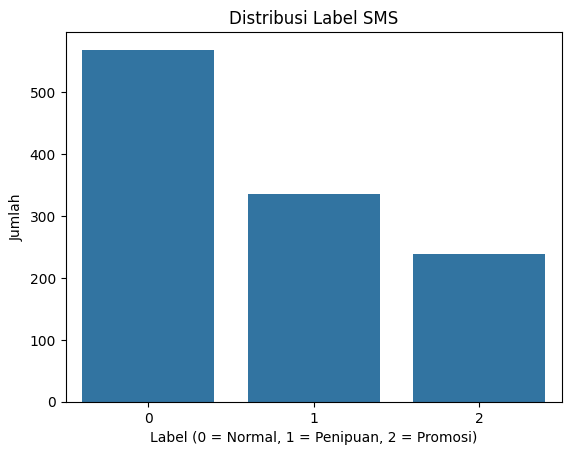

In [ ]:
# Distribusi label
sns.countplot(x='label', data=df)
plt.title("Distribusi Label SMS")
plt.xlabel("Label (0 = Normal, 1 = Penipuan, 2 = Promosi)")
plt.ylabel("Jumlah")
plt.show()


## 🔢 Distribusi Label Target

Visualisasi di atas menunjukkan distribusi jumlah SMS pada masing-masing kelas target:

- **Label 0 (Normal)**: Mewakili pesan SMS yang tidak mengandung unsur penipuan maupun promosi. Kelas ini mendominasi dataset dengan **569 data**.
- **Label 1 (Penipuan)**: Berisi SMS yang tergolong sebagai pesan penipuan atau modus kejahatan digital. Jumlahnya sebanyak **335 data**.
- **Label 2 (Promosi)**: Mencakup pesan yang bertujuan untuk menawarkan produk, layanan, atau iklan. Terdapat **239 data** dalam kelas ini.

Distribusi ini menunjukkan bahwa **dataset tidak seimbang secara sempurna**, dengan kelas normal memiliki jumlah data yang lebih tinggi dibandingkan kelas penipuan dan promosi. Ketidakseimbangan ini perlu diperhatikan karena dapat memengaruhi performa model klasifikasi, terutama terhadap kelas minoritas seperti penipuan dan promosi. Pendekatan seperti **penyesuaian bobot, oversampling (misalnya SMOTE), atau evaluasi dengan metrik F1-Score per kelas** dapat menjadi strategi untuk mengatasi masalah ini saat pelatihan model.


## ⚖️ Catatan Mengenai Imbalance Data

Meskipun distribusi label pada dataset ini tidak seimbang sempurna — dengan jumlah SMS normal (label 0) lebih banyak dibandingkan penipuan (label 1) dan promosi (label 2) — **proses balancing data seperti oversampling (contoh: SMOTE) atau undersampling tidak akan dilakukan dalam studi ini**.

### Alasan:
- **Data teks memerlukan tahapan transformasi yang kompleks** seperti tokenisasi, padding, dan normalisasi (contohnya TF-IDF atau embedding BERT). Jika dilakukan balancing sebelum atau sesudah proses ini, dapat menyebabkan **duplikasi konteks yang tidak alami**, memperbesar risiko **overfitting** pada model.
- Proses **normalisasi** dan encoding pada model berbasis teks sensitif terhadap **jumlah kemunculan token dan struktur kalimat**. Menambah data sintetis atau menggandakan data minoritas bisa menimbulkan **distorsi distribusi kata**, terutama dalam pendekatan berbasis transformer seperti BERT.
- Fokus dari eksperimen ini adalah **membandingkan kinerja dua pendekatan model**, bukan memaksimalkan performa absolut. Oleh karena itu, mempertahankan distribusi asli dataset justru mencerminkan kondisi yang lebih realistis dalam kasus nyata (production use case).

Sebagai gantinya, evaluasi model akan menggunakan metrik yang **memperhatikan ketidakseimbangan data**, seperti **F1-Score per kelas**, bukan hanya akurasi keseluruhan.


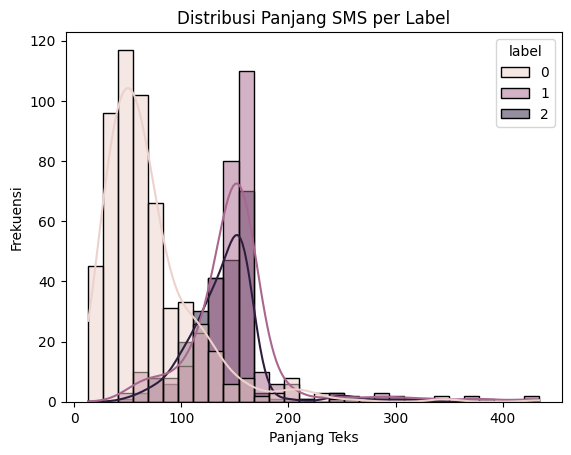

In [ ]:
# Buat kolom panjang karakter
df['text_length'] = df['Teks'].apply(len)

# Statistik panjang
df['text_length'].describe()

# Visualisasi distribusi panjang
sns.histplot(data=df, x='text_length', hue='label', bins=30, kde=True)
plt.title("Distribusi Panjang SMS per Label")
plt.xlabel("Panjang Teks")
plt.ylabel("Frekuensi")
plt.show()


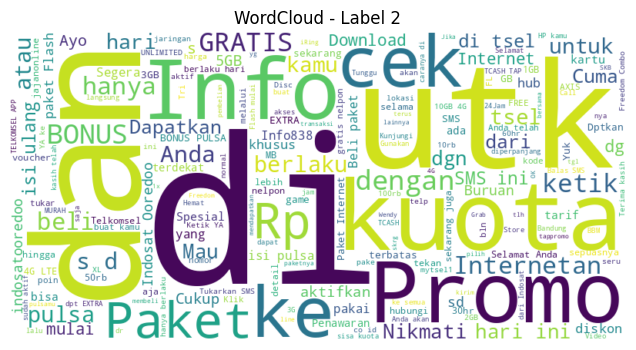

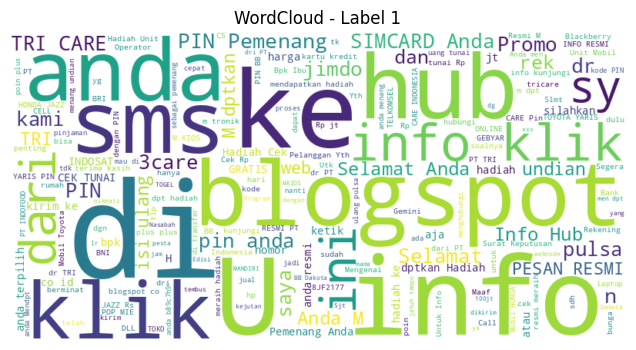

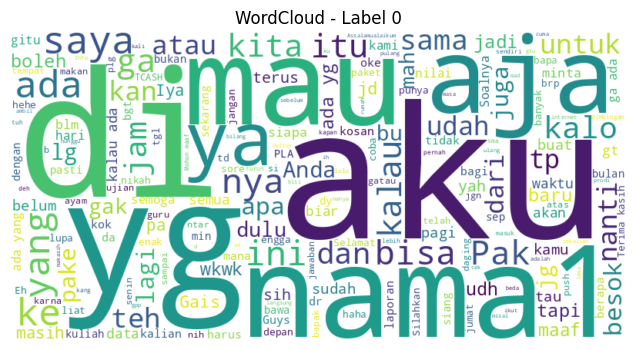

In [ ]:
from wordcloud import WordCloud

# Gabungkan teks berdasarkan label
for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['Teks'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - Label {label}")
    plt.show()


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Teks'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

# Evaluasi
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       114
           1       0.87      0.88      0.87        67
           2       0.89      0.85      0.87        48

    accuracy                           0.92       229
   macro avg       0.91      0.90      0.90       229
weighted avg       0.92      0.92      0.92       229



In [ ]:
import transformers
print(transformers.__version__)

4.52.4


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import numpy as np
# 🔀 Split data (manual stratified split)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 🔄 Konversi ke Dataset HuggingFace
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# 🔤 Tokenisasi IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def tokenize(example):
    return tokenizer(example["Teks"], truncation=True, padding="max_length", max_length=128)


train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

# 🧠 Load IndoBERT dengan 3 output label
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)

# ⚙️ Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
)

# 🧪 Trainer Setup
import os
os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
)

# 🚀 Train model
trainer.train()

Map:   0%|          | 0/914 [00:00<?, ? examples/s]

Map:   0%|          | 0/229 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-11-3014716961>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.176100,0.194908
2,0.065900,0.175474
3,0.049100,0.188869


TrainOutput(global_step=174, training_loss=0.14236042888342648, metrics={'train_runtime': 3843.9073, 'train_samples_per_second': 0.713, 'train_steps_per_second': 0.045, 'total_flos': 180364247852544.0, 'train_loss': 0.14236042888342648, 'epoch': 3.0})

In [ ]:

preds = trainer.predict(test_tokenized)

y_pred = preds.predictions.argmax(axis=-1)
y_true = preds.label_ids

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       114
           1       0.94      0.96      0.95        67
           2       0.91      0.90      0.91        48

    accuracy                           0.96       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.96      0.96      0.96       229



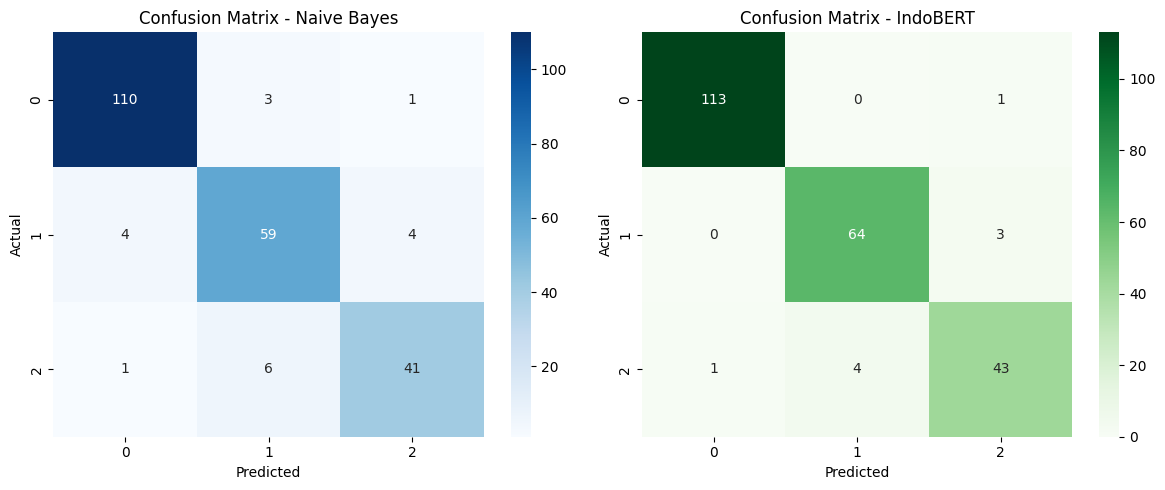

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# === Akurasi Naive Bayes ===
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_cm = confusion_matrix(y_test, y_pred_nb)

# === Akurasi IndoBERT ===

indobert_accuracy = accuracy_score(y_true, y_pred)
indobert_cm = confusion_matrix(y_true, y_pred)

# === Tabel Perbandingan Akurasi ===
accuracy_df = pd.DataFrame({
    "Model": ["Naive Bayes + TF-IDF", "Fine-tuned IndoBERT"],
    "Accuracy": [nb_accuracy, indobert_accuracy]
})

# === Plot Confusion Matrix untuk Kedua Model ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Naive Bayes")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(indobert_cm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix - IndoBERT")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()



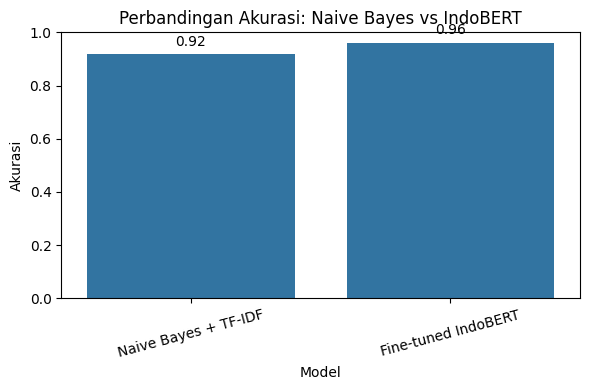

In [ ]:
# Plot dengan label angka akurasi di atas bar
plt.figure(figsize=(6, 4))
barplot = sns.barplot(x="Model", y="Accuracy", data=accuracy_df)
plt.title("Perbandingan Akurasi: Naive Bayes vs IndoBERT")
plt.ylabel("Akurasi")
plt.ylim(0, 1)
plt.xticks(rotation=15)

for i, bar in enumerate(barplot.patches):
    height = bar.get_height()
    barplot.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()
